In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import re
import copy
import json

In [2]:
PIECES_TO_NUM = {
    "square": 0,
    "white_pawn": 1,
    "white_rook": 2,
    "white_knight": 3,
    "white_bishop": 4,
    "white_king": 5,
    "white_queen": 6,
    "white_unknown": 7,
    "black_pawn": -1,
    "black_rook": -2,
    "black_knight": -3,
    "black_bishop": -4,
    "black_king": -5,
    "black_queen": -6,
    "black_unknown": -7,
}

NUM_TO_PIECE = {
    0: "square",
    1: "white_pawn",
    2: "white_rook",
    3: "white_knight",
    4: "white_bishop",
    5: "white_king",
    6: "white_queen",
    7: "white_unknown",
    -1: "black_pawn",
    -2: "black_rook",
    -3: "black_knight",
    -4: "black_bishop",
    -5: "black_king",
    -6: "black_queen",
    -7: "black_unknown"
}

In [3]:
piece_images = {
    piece: Image.open(f'../../assets/{piece}.png') for piece in PIECES_TO_NUM.keys() if piece != "square"
}

In [4]:
game_state = np.array([
    [-2, -3, -4, -6, -5, -4, -3, -2],
    [-1, -1, -1, -1, -1, -1, -1, -1],
    [ 0,  0,  0,  0,  0,  0,  0,  -7],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  0],
    [ 0,  0,  0,  0,  0,  0,  0,  7],
    [ 1,  1,  1,  1,  1,  1,  1,  1],
    [ 2,  3,  4,  6,  5,  4,  3,  2],
])

def draw_chessboard(board, save=False, show=False):
    board = np.flipud(board)
    fig, ax = plt.subplots()

    chessboard_pattern = np.zeros((8, 8))
    chessboard_pattern[1::2, ::2] = 1
    chessboard_pattern[::2, 1::2] = 1

    ax.imshow(chessboard_pattern, cmap='gray', interpolation='none')

    for i in range(8):
        for j in range(8):
            piece_value = board[i, j]
            if piece_value != 0:
                piece_name = NUM_TO_PIECE[piece_value]
                piece_image = piece_images[piece_name]
                ax.imshow(piece_image, extent=[j - 0.5, j + 0.5, i - 0.5, i + 0.5])

    ax.set_xticks(np.arange(8))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks(np.arange(-0.5, 8, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 8, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)

    if save:
        fig.savefig(f"{save}.png")

    if show: plt.show()
    
    matplotlib.pyplot.close()
    
draw_chessboard(game_state)


In [5]:
def modify_game_state(game_state, move):
    new_game_state = copy.copy(np.flipud(game_state)) # A1 is 0,0
    if " -> " in move:
        init_pos = move.split(" -> ")[0]
        new_pos = move.split(" -> ")[1]

        init_y_pos = int(init_pos[-1]) - 1
        init_x_pos = int(ord(init_pos[-2]) - 96 - 1)

        new_y_pos = int(new_pos[-1]) - 1
        new_x_pos = int(ord(new_pos[-2]) - 96 - 1)      

        piece = new_game_state[init_y_pos, init_x_pos]
        new_game_state[init_y_pos, init_x_pos] = 0
        new_game_state[new_y_pos, new_x_pos] = piece

    elif " + " in move:
        init_pos = move.split(" + ")[0]
        new_pos = move.split(" + ")[1]

        init_y_pos = int(init_pos[-1]) - 1
        init_x_pos = int(ord(init_pos[-2]) - 96 - 1)

        new_y_pos = int(new_pos[-1]) - 1
        new_x_pos = int(ord(new_pos[-2]) - 96 - 1)      

        piece = new_game_state[init_y_pos, init_x_pos]
        new_game_state[init_y_pos, init_x_pos] = 0
        new_game_state[new_y_pos, new_x_pos] = piece

    elif " x " in move:
        init_pos = move.split(" x ")[0]
        new_pos = move.split(" x ")[1]

        init_y_pos = int(init_pos[-1]) - 1
        init_x_pos = int(ord(init_pos[-2]) - 96 - 1)

        new_y_pos = int(new_pos[-1]) - 1
        new_x_pos = int(ord(new_pos[-2]) - 96 - 1)      

        piece = new_game_state[init_y_pos, init_x_pos]
        new_game_state[init_y_pos, init_x_pos] = 0
        new_game_state[new_y_pos, new_x_pos] = piece

    elif "O-O-O" in move:
        if move[0] == "w":
            new_game_state[0, 2] = new_game_state[0, 4]
            new_game_state[0, 3] = new_game_state[0, 0]
            new_game_state[0, 0] = 0
            new_game_state[0, 4] = 0
        else:
            new_game_state[7, 2] = new_game_state[7, 4]
            new_game_state[7, 3] = new_game_state[7, 0]
            new_game_state[7, 0] = 0
            new_game_state[7, 4] = 0

    elif "O-O" in move:
        if move[0] == "w":
            new_game_state[0, 6] = new_game_state[0, 4]
            new_game_state[0, 5] = new_game_state[0, 7]
            new_game_state[0, 7] = 0
            new_game_state[0, 4] = 0
        else:
            new_game_state[7, 6] = new_game_state[7, 4]
            new_game_state[7, 5] = new_game_state[7, 7]
            new_game_state[7, 7] = 0
            new_game_state[7, 4] = 0
        

    return np.flipud(new_game_state)

In [33]:
def analyze_move(prev_state, curr_state):
    """
    Compare two successive chess board states and determine the move made.
    
    Args:
        prev_state: numpy array of previous board state
        curr_state: numpy array of current board state
    
    Returns:
        dict with:
            - valid (bool): if the move appears valid
            - move_type (str): 'move', 'capture', or 'invalid'
            - from_pos (tuple): starting position (row, col)
            - to_pos (tuple): ending position (row, col)
            - piece (int): piece value that was moved
            - captured (int): piece value that was captured (if any)
    """
    # Convert to numpy arrays if not already
    prev_state = np.array(prev_state)
    curr_state = np.array(curr_state)
    
    # Find differences between states
    diff = curr_state - prev_state
    changes = np.where(diff != 0)

    print('changes', changes)
    
    # Get positions where changes occurred
    positions = list(zip(changes[0], changes[1]))

    print('positions', positions)

    
    # If no changes or more than 2 positions changed, invalid move
    if len(positions) == 0 :
        return {
            'valid': False,
            'move_type': 'invalid',
            'message': 'No changes detected'
        }
    
    elif len(positions) > 2:
        return {
            'valid': False,
            'move_type': 'invalid',
            'message': 'Invalid number of position changes'
        }
    
    # For a basic move (no capture)
    if len(positions) == 2:


        pos1, pos2 = positions
        
        initial_pos = None
        final_pos = None

        if prev_state[pos1] == 0:
            initial_pos = pos1
            final_pos = pos2
        else:
            initial_pos = pos2
            final_pos = pos1

        moving_piece = prev_state[initial_pos]

        print('moving_piece', moving_piece)
        
        # Position final avant le mouvement
        initial_final_pos = prev_state[final_pos]

        print('initial_final_pos', initial_final_pos)

        from_square = f"{chr(97 + initial_pos[1])}{8 - initial_pos[0]}"
        to_square = f"{chr(97 + final_pos[1])}{8 - final_pos[0]}"

        # Simple move
        if initial_final_pos == 0:

            move = f"{from_square} -> {to_square}"

            print('move', move)

            # new_gs = modify_game_state(prev_state, move)

            # diff = curr_state - new_gs
            # changes = np.where(diff != 0)

            # print('valid game state', len(changes))

            return {
                'valid': True,
                'move_type': 'move',
                'from_pos': initial_pos,
                'to_pos': final_pos,
                'piece': moving_piece,
            }

        # Capture
        else:

            move = f"{from_square} x {to_square}"

            print('move', move)

            # new_gs = modify_game_state(prev_state, move)

            # diff = curr_state - new_gs
            # changes = np.where(diff != 0)

            # print('valid game state', len(changes))

            return {
                'valid': True,
                'move_type': 'capture',
                'from_pos': initial_pos,
                'to_pos': final_pos,
                'piece': moving_piece
            }

            pass
    
    return {
        'valid': False,
        'move_type': 'invalid',
        'message': 'Unrecognized move pattern'
    }

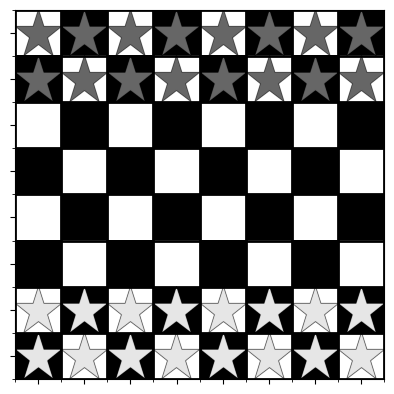

##############################################

Game state 0 (Frame: warped_frame_000100.png):
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected
##############################################

Game state 1 (Frame: warped_frame_000150.png):
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected
##############################################

Game state 2 (Frame: warped_frame_000400.png):
changes (array([1, 3], dtype=int64), array([4, 4], dtype=int64))
positions [(1, 4), (3, 4)]
moving_piece 0
initial_final_pos -7
valid game state 2
Capture: e5 x e7


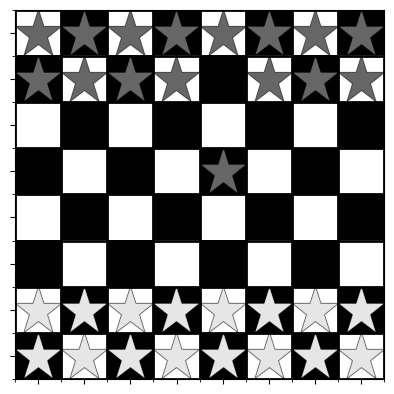

##############################################

Game state 3 (Frame: warped_frame_000450.png):
changes (array([6], dtype=int64), array([0], dtype=int64))
positions [(6, 0)]
Invalid move: Unrecognized move pattern
##############################################

Game state 4 (Frame: warped_frame_000500.png):
changes (array([6], dtype=int64), array([0], dtype=int64))
positions [(6, 0)]
Invalid move: Unrecognized move pattern
##############################################

Game state 5 (Frame: warped_frame_000550.png):
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected
##############################################

Game state 6 (Frame: warped_frame_000600.png):
changes (array([], dtype=int64), array([], dtype=int64))
positions []
Invalid move: No changes detected
##############################################

Game state 7 (Frame: warped_frame_000650.png):
changes (array([7, 7], dtype=int64), array([2, 3], dtype=int64))
positions [(7, 2

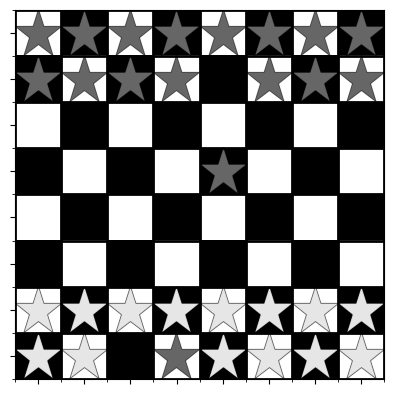

##############################################

Game state 8 (Frame: warped_frame_000800.png):
changes (array([1, 5, 7, 7, 7], dtype=int64), array([0, 2, 1, 2, 3], dtype=int64))
positions [(1, 0), (5, 2), (7, 1), (7, 2), (7, 3)]
Invalid move: Invalid number of position changes
##############################################

Game state 9 (Frame: warped_frame_000850.png):
changes (array([5, 7, 7, 7], dtype=int64), array([2, 1, 2, 3], dtype=int64))
positions [(5, 2), (7, 1), (7, 2), (7, 3)]
Invalid move: Invalid number of position changes
##############################################

Game state 10 (Frame: warped_frame_001100.png):
changes (array([1, 3, 5, 6, 7, 7, 7], dtype=int64), array([5, 5, 2, 0, 1, 2, 3], dtype=int64))
positions [(1, 5), (3, 5), (5, 2), (6, 0), (7, 1), (7, 2), (7, 3)]
Invalid move: Invalid number of position changes
##############################################

Game state 11 (Frame: warped_frame_001150.png):
changes (array([1, 3, 5, 7, 7, 7], dtype=int64), array(

In [32]:


# Read the game states from game_state.json
with open('game_state.json', 'r') as f:
    game_data = json.load(f)


last_game_state = game_data['game_states'][0]['gs']

draw_chessboard(last_game_state, show=True)


# Display each game state
for i, state in enumerate(game_data['game_states'][1:]):

    print('\n##############################################')
    print(f"\nGame state {i} (Frame: {state['frame']}):")

    

    valid_move = True

    
    curr_state = np.array(state['gs'])
    move_analysis = analyze_move(last_game_state, curr_state)

    valid_move = move_analysis['valid']
    
    if move_analysis['valid']:
        from_pos = move_analysis['from_pos']
        to_pos = move_analysis['to_pos']
        piece = move_analysis['piece']
        
        # Convertir les positions en notation d'échecs
        from_square = f"{chr(97 + from_pos[1])}{8 - from_pos[0]}"
        to_square = f"{chr(97 + to_pos[1])}{8 - to_pos[0]}"
        
        if move_analysis['move_type'] == 'move':
            print(f"Move: {from_square} -> {to_square}")
        else:  # capture
            print(f"Capture: {from_square} x {to_square}")

        draw_chessboard(curr_state, show=True)

        last_game_state = curr_state
    else:
        print(f"Invalid move: {move_analysis['message']}")

    
    


    
    
    
    
